# 1. Dataset
Download the movieLens dataset:
http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

The data are represented by 100836 rows and 4 columns called userId, movieId, rating et timestamp. We will work
only with the 3 first columns which are userId, movieId, rating. These data are made by 610 users rating more or less 10
movies each among 9724 movies.

In [1]:
import os
import requests
import zipfile

# Get the current working directory
current_directory = os.getcwd()

# Set the path for the 'data' directory
data_directory = os.path.join(current_directory, 'data')
os.makedirs(data_directory, exist_ok=True)

# URL and file paths
url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
filename = "ml-latest-small.zip"
unzipped_folder_name = filename.replace('.zip', '')
path_zip = os.path.join(data_directory, filename)
path_unzipped = os.path.join(data_directory, unzipped_folder_name)

# Check if the unzipped folder already exists
if not os.path.exists(path_unzipped):
    print(f"Folder {unzipped_folder_name} not found. Downloading and unzipping...")

    # Download the zip file
    response = requests.get(url)
    with open(path_zip, 'wb') as file:
        file.write(response.content)
    print("Download completed.")

    # Unzip the file
    with zipfile.ZipFile(path_zip, 'r') as zip_ref:
        zip_ref.extractall(data_directory)
    print("Unzipping completed.")

    # Delete the zip file
    os.remove(path_zip)
    print("Zip file deleted.")
else:
    print(f"Folder {unzipped_folder_name} already exists.")


Folder ml-latest-small already exists.


In [2]:
import pandas as pd

ratings_filename = "ratings.csv"
path_ratings = os.path.join(path_unzipped, ratings_filename)
ratings = pd.read_csv(path_ratings)
ratings.tail(5)


,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [3]:
from scipy.sparse import coo_matrix

sparse_matrix = coo_matrix((ratings['rating'], (ratings['movieId'], ratings['userId'])))

# csr for slicing capabilities
sparse_matrix_csr = sparse_matrix.tocsr()
rows_with_ratings = sparse_matrix_csr.sum(axis=1).A1 != 0
ratings_matrix = sparse_matrix_csr[rows_with_ratings]

print(ratings_matrix.shape)

(9724, 611)


# 2. Minimal rank choice of a matrix
Determine graphically and empirically the rank r of the matrix movies×users as it follows :
For the matrix completion problem, in the first step of our SVP method, we compute singular values incrementally till we find
no more significant gap between singular values : the gap between the rth and r + 1th singular value should be small compared
to the first ones.

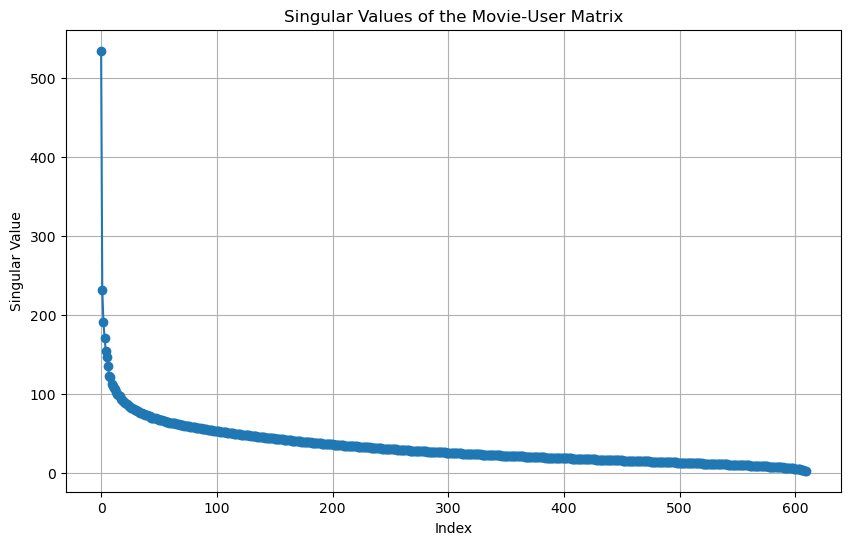

In [4]:
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds

# k, number of singular values, so minimum of the shape
k = min(ratings_matrix.shape) - 1 
u, s, vt = svds(ratings_matrix, k=k)

# Values in descending order, order of importance 
singular_values = sorted(s, reverse=True)

# Plot the singular values
plt.figure(figsize=(10, 6))
plt.plot(singular_values, 'o-')
plt.title("Singular Values of the Movie-User Matrix")
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.grid()
plt.show()


In [5]:
import numpy as np

differences = -np.diff(singular_values)

# Criterion for a significant gap
significance = .01

threshold = significance * differences[0]
significant_rank = np.argmax(differences < threshold) + 1

print(f"The significant rank is: {significant_rank}. \nThis rank is determined as the point where the gap between "
      f"consecutive singular values is less than {significance * 100:.2f}% of the first gap.")

The significant rank is: 8. 
This rank is determined as the point where the gap between consecutive singular values is less than 1.00% of the first gap.


In [6]:
import numpy as np
from numpy.linalg import svd
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from scipy.sparse import find, csr_matrix, lil_matrix

def compute_residuals(X, ratings, indices):
    """
    Compute residuals for known entries.
    """
    rows, cols = indices
    residual_values = ratings - X[rows, cols]
    return residual_values

def perform_svd_and_reconstruct(matrix, rank=None, cut_off=None, return_bases=False):
    """
    Perform SVD on the given matrix and reconstruct it using specified rank.
    """
    # In strict theoretical sense, this is deviating from the theory. 
    # However, we want to keep using svds for efficiency reasons.
    if rank is None:
        U, sigma, Vt = svd(matrix, full_matrices=False)
    else:
        U, sigma, Vt = svds(matrix, k=rank)
    
    if cut_off is not None:
        sigma = soft_threshold(sigma, cut_off)
        
    reconstructed_matrix = U @ np.diag(sigma) @ Vt
    
    if return_bases:
        bases = [csr_matrix(np.outer(U[:, k], Vt[k, :])) for k in range(rank)]
        return reconstructed_matrix, bases
    
    return reconstructed_matrix

def update_matrix(X, updates, indices):
    """
    Efficiently update matrix X at specified indices with given updates.
    """
    rows, cols = indices
    X[rows, cols] += updates
    return X

# def compute_rmse(X, ratings, indices):
#     """
#     Compute RMSE for known entries.
#     """
#     return np.sqrt(np.mean(compute_residuals(X, ratings, indices) ** 2))

def compute_rmse(residuals):
    """
    Compute RMSE for known entries.
    """
    return np.sqrt(np.mean(residuals ** 2))


def soft_threshold(x, lambda_val):
    """
    Apply soft-thresholding to the input array.
    
    Parameters:
    - x: input array.
    - lambda_val: thresholding parameter.
    
    Returns:
    - thresholded array.
    """
    return np.sign(x) * np.maximum(np.abs(x) - lambda_val, 0)




# 3. Implementation and application
Implement and test on the dataset the 3 approaches proposed below :

## 3.1 Singular Value Projection algorithm

Iteration 32, RMSE: 0.9493763406964905


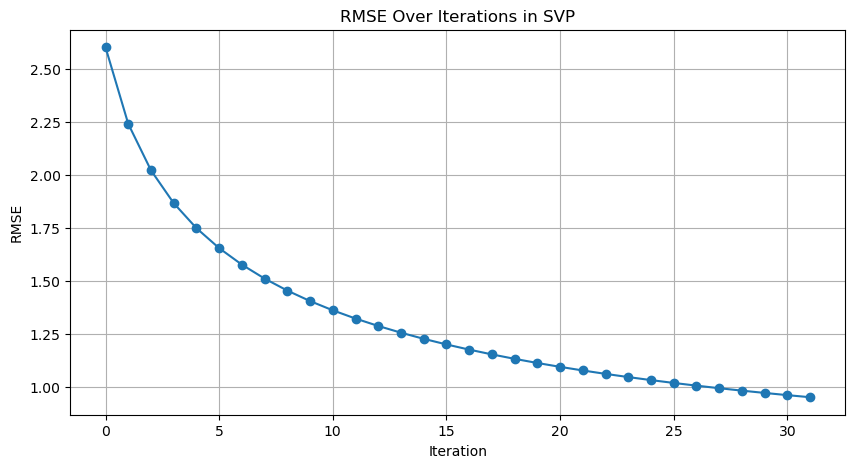

Best RMSE obtained: 0.9493763406964905


In [7]:
def svp_algorithm(ratings_matrix, rank, epsilon=0.01):
    """
    Singular Value Projection (SVP) Algorithm for Matrix Completion.
    """
    rows, cols, ratings = find(ratings_matrix)
    X_hat = np.zeros(ratings_matrix.shape)
    best_X_hat = np.copy(X_hat)
    best_rmse = float('inf')
    rmse_values = []
    convergence = False
    residuals = compute_residuals(X_hat, ratings, (rows, cols))

    while not convergence:
        X_hat[rows, cols] += residuals
        X_hat = perform_svd_and_reconstruct(X_hat, rank=rank)

        residuals = compute_residuals(X_hat, ratings, (rows, cols))
        rmse_current = compute_rmse(residuals)
        rmse_values.append(rmse_current)
        
        if rmse_current < best_rmse:
            best_rmse = rmse_current
            best_X_hat = np.copy(X_hat)
        
        if len(rmse_values) > 1 and rmse_current > rmse_values[-2] - epsilon:
            convergence = True

        
        print(f'\rIteration {len(rmse_values)}, RMSE: {rmse_current}', end='')
    print()

    return best_X_hat, rmse_values

X_hat, rmse_values = svp_algorithm(ratings_matrix, significant_rank)

# Plot the RMSE values
plt.figure(figsize=(10, 5))
plt.plot(rmse_values, marker='o')
plt.title('RMSE Over Iterations in SVP')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid()
plt.show()

# Output the final RMSE and the best RMSE obtained
print(f"Best RMSE obtained: {min(rmse_values)}")

## 3.2. Convex relaxation algorithm
Note that the parameter λ should be carefully chosen. Note also that a gradient step size can be put in step 3, in the aim to
improve the convergence of the algorithm.

Iteration 18, RMSE: 2.0490082330459613


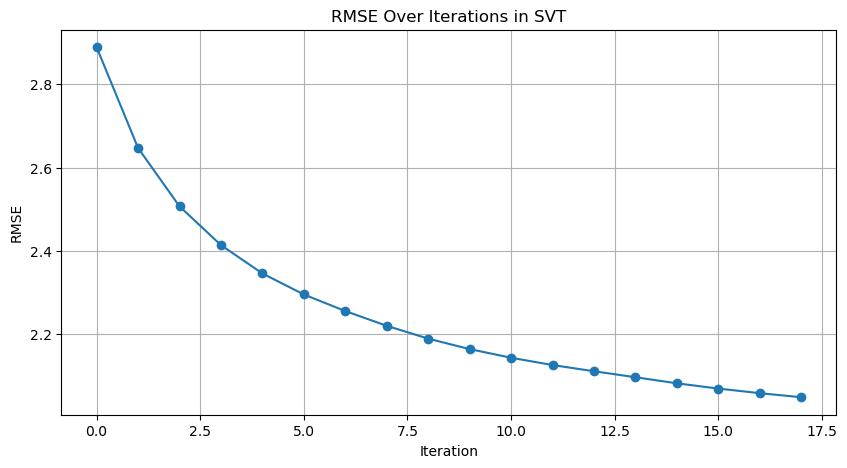

Best RMSE obtained: 2.049008233045961


In [8]:
def svt_algorithm(ratings_matrix, cut_off, step_size=1.0, epsilon=0.01):
    """
    Singular Value Thresholding (SVT) Algorithm for Matrix Completion.
    """
    rows, cols, ratings = find(ratings_matrix)
    X_hat = np.zeros(ratings_matrix.shape)
    best_X_hat = np.copy(X_hat)
    best_rmse = float('inf')
    rmse_values = []
    convergence = False
    residuals = compute_residuals(X_hat, ratings, (rows, cols))

    while not convergence:
        X_hat[rows, cols] += step_size * residuals
        X_hat = perform_svd_and_reconstruct(X_hat, cut_off=cut_off)
        residuals = compute_residuals(X_hat, ratings, (rows, cols))
        rmse_current = compute_rmse(residuals)
        rmse_values.append(rmse_current)
        

        if rmse_current < best_rmse:
            best_rmse = rmse_current
            best_X_hat = np.copy(X_hat)

        if len(rmse_values) > 1 and rmse_current > rmse_values[-2] - epsilon:
            convergence = True
        
        print(f'\rIteration {len(rmse_values)}, RMSE: {rmse_current}', end='')
    print()

    return best_X_hat, rmse_values

cut_off = 100
X_hat, rmse_values = svt_algorithm(ratings_matrix, cut_off)


# Plot the RMSE values
plt.figure(figsize=(10, 5))
plt.plot(rmse_values, marker='o')
plt.title('RMSE Over Iterations in SVT')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid()
plt.show()

# Output the final RMSE and the best RMSE obtained
print(f"Best RMSE obtained: {min(rmse_values)}")

## 3.3. ADMiRA algorithm
The choice of the parameter r will be the same as the ones defined in question 2. The notations are the same than in the course
notes.

Iteration 9, RMSE: 1.207661846296377, Relative Error: 0.33055306460082162


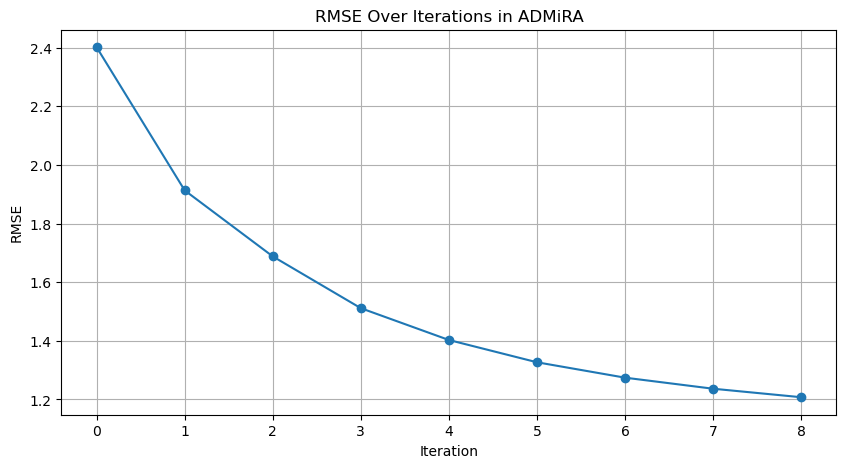

Best RMSE obtained: 1.207661846296377


In [9]:
def admira_algorithm(ratings_matrix, rank, epsilon=0.01):
    """
    ADMiRA Algorithm for Matrix Completion.
    """
    rows, cols, ratings = find(ratings_matrix)
    norm_y = np.linalg.norm(ratings)
    X_hat = np.zeros(ratings_matrix.shape)
    best_X_hat = np.copy(X_hat)
    best_rmse = float('inf')
    Psi_matrices = []
    rmse_values = []
    relative_errors = [] 
    convergence = False

    residuals = compute_residuals(X_hat, ratings, (rows, cols))

    while not convergence:
        residual_matrix = np.zeros(ratings_matrix.shape)
        residual_matrix[rows, cols] = residuals

        U, sigma, Vt = svds(residual_matrix, 2 * rank)
        Psi_prime = [csr_matrix(np.outer(U[:, k], Vt[k, :])) for k in range(2 * rank)]
        Psi_matrices.extend(Psi_prime)

        # No Orthogonalization
        Psi_known = np.vstack([psi[rows, cols].A1 for psi in Psi_matrices])
        coefficients, _, _, _ = np.linalg.lstsq(Psi_known.T, ratings, rcond=None)

        # Orthogonalize 
        # Q, R = np.linalg.qr(Psi_known.T)
        # Psi_orthogonalized = Q.T
        # coefficients, _, _, _ = np.linalg.lstsq(Psi_orthogonalized.T, ratings, rcond=None)
        
        X_e = sum(psi.multiply(coeff) for psi, coeff in zip(Psi_matrices, coefficients))
        X_hat, Psi_matrices = perform_svd_and_reconstruct(X_e, rank, return_bases=True)

        residuals = compute_residuals(X_hat, ratings, (rows, cols))
        rmse_current = compute_rmse(residuals)
        rmse_values.append(rmse_current)
        
        # Compute the norm of residuals
        norm_residuals = np.linalg.norm(residuals)

        relative_errors.append(norm_residuals / norm_y)

        if rmse_current < best_rmse:
            best_rmse = rmse_current
            best_X_hat = np.copy(X_hat)
        
        if len(rmse_values) > 1 and (relative_errors[-1] > relative_errors[-2] - epsilon):
            convergence = True

        print(f'\rIteration {len(rmse_values)}, RMSE: {rmse_current}, Relative Error: {relative_errors[-1]}', end='')
    print()

    return best_X_hat, rmse_values

X_hat, rmse_values = admira_algorithm(ratings_matrix, significant_rank)

# Plot the RMSE values
plt.figure(figsize=(10, 5))
plt.plot(rmse_values, marker='o')
plt.title('RMSE Over Iterations in ADMiRA')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid()
plt.show()

# Output the best RMSE obtained
print(f"Best RMSE obtained: {min(rmse_values)}")

In [29]:
import numpy as np
from scipy.sparse import find, csr_matrix
from sklearn.model_selection import ParameterGrid
from copy import deepcopy

def create_folds(ratings_matrix, num_folds):
    """Create k folds by randomly hiding a portion of the ratings."""
    rows, cols, ratings = find(ratings_matrix)
    indices = np.arange(len(ratings))
    np.random.shuffle(indices)

    # Adjust the number of folds if it's larger than the dataset size
    num_folds = min(num_folds, len(ratings))
    
    fold_size = len(ratings) // num_folds
    remainder = len(ratings) % num_folds
    start_idx = 0
    folds = []

    for i in range(num_folds):
        if i < remainder:
            # Distribute the remainder among the first few folds
            end_idx = start_idx + fold_size + 1
        else:
            end_idx = start_idx + fold_size

        test_indices = indices[start_idx:end_idx]
        start_idx = end_idx

        # Create the training set by hiding the test ratings
        train_set = deepcopy(ratings_matrix)
        train_set[rows[test_indices], cols[test_indices]] = 0

        # Create the test set
        test_set = csr_matrix((ratings[test_indices], (rows[test_indices], cols[test_indices])), shape=ratings_matrix.shape)

        folds.append((train_set, test_set))

    return folds


def train_and_evaluate_model(train_set, test_set, algorithm, return_train=False, **params):
    """ Train the model using the specified algorithm and parameters, and evaluate on the test set. """
    if algorithm == 'admira':
        X_hat, train_scores = admira_algorithm(train_set, **params)
    elif algorithm == 'svp':
        X_hat, train_scores = svp_algorithm(train_set, **params)
    elif algorithm == 'svt':
        X_hat, train_scores = svt_algorithm(train_set, **params)
    else:
        raise ValueError("Invalid algorithm specified")

    # Compute RMSE on test set
    rows, cols, ratings = find(test_set)
    residuals = compute_residuals(X_hat, ratings, (rows, cols))
    rmse = compute_rmse(residuals)    

    if return_train:
        return rmse, train_scores
    return rmse


In [25]:
def cross_validate(ratings_matrix, algorithm, param_grid, num_folds=5):
    folds = create_folds(ratings_matrix, num_folds)

    best_score = float('inf')
    best_params = None

    for params in ParameterGrid(param_grid):
        scores = []

        for train_set, test_set in folds:
            score = train_and_evaluate_model(train_set, test_set, algorithm, **params)
            print(f'Evaluation, Fold: {len(scores)} RMSE: {score}, parameters: {params=}')
            scores.append(score)

        avg_score = sum(scores) / len(scores)

        if avg_score < best_score:
            best_score = avg_score
            best_params = params

    return best_params, best_score


In [40]:
from scipy.sparse import coo_matrix

def split_data(ratings_matrix, test_size=0.1):
    """ Split the data into training and test sets. """
    rows, cols, ratings = find(ratings_matrix)
    num_ratings = len(ratings)
    num_test = int(num_ratings * test_size)
    
    indices = np.arange(num_ratings)
    np.random.shuffle(indices)
    
    test_indices = indices[:num_test]
    
    train_set = deepcopy(ratings_matrix)
    
    # Set test indices in the training set to zero and vice versa
    train_set[rows[test_indices], cols[test_indices]] = 0
    train_set.eliminate_zeros()
    test_set = csr_matrix((ratings[test_indices], (rows[test_indices], cols[test_indices])), shape=ratings_matrix.shape)

    
    return train_set, test_set

# Split the data into a training set and a hold-out test set
train_ratings_matrix, test_ratings_matrix = split_data(ratings_matrix)

Iteration 17, RMSE: 1.8243329319556618
SVT RMSE: 1.9540820974346296


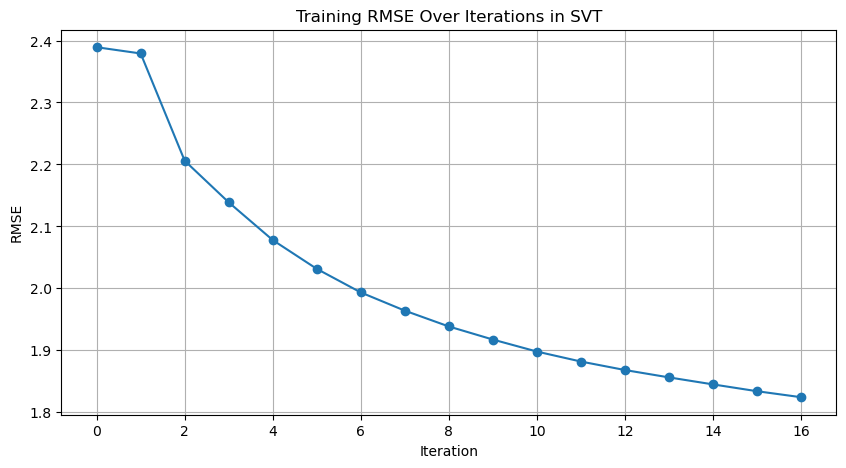

In [44]:

param_grid = {
    # 'cut_off': [10**i for i in range(-5, 5)],  # different ranks to test
    # 'step_size': [0.1, 0.5, 1, 1.5, 2],
    'cut_off': [100],
    'step_size': [1.5],
    'epsilon': [0.01]  # can include different epsilon values if needed
}

algorithm = 'svt'
# best_params, best_score = cross_validate(train_ratings_matrix, algorithm, param_grid, num_folds=5)

# print(f"Best Parameters: {best_params}")
# score, train_scores = train_and_evaluate_model(train_ratings_matrix, test_ratings_matrix, algorithm, return_train=True, **best_params)

score, train_scores = train_and_evaluate_model(train_ratings_matrix, test_ratings_matrix, algorithm, return_train=True, step_size=1.5, cut_off=100)
print(f"SVT RMSE: {score}")

# Plot the RMSE values
plt.figure(figsize=(10, 5))
plt.plot(train_scores, marker='o')
plt.title('Training RMSE Over Iterations in SVT')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid()
plt.show()


Iteration 33, RMSE: 0.9580823769863496
SVP RMSE: 1.5054525405262187


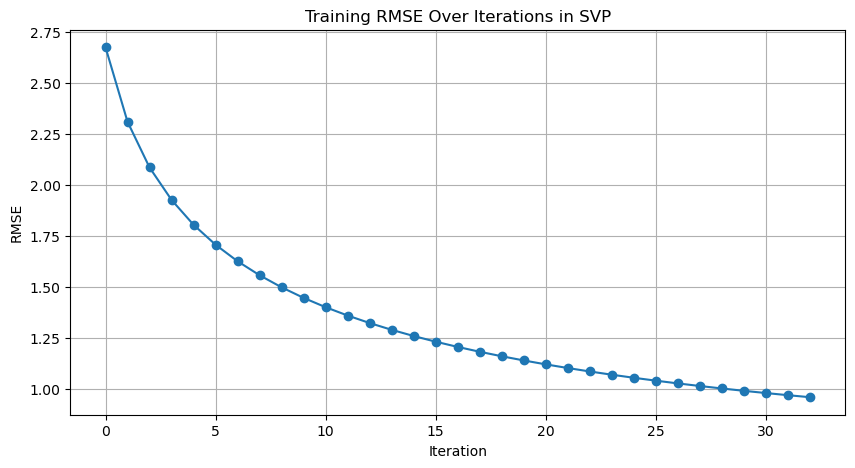

In [42]:

test_score, train_scores = train_and_evaluate_model(train_ratings_matrix, test_ratings_matrix, 'svp', return_train=True, rank=significant_rank)
print(f"SVP RMSE: {test_score}")

# Plot the RMSE values
plt.figure(figsize=(10, 5))
plt.plot(train_scores, marker='o')
plt.title('Training RMSE Over Iterations in SVP')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid()
plt.show()

Iteration 9, RMSE: 1.2283805029748254, Relative Error: 0.33624264204075436
ADMiRA RMSE: 1.6312692124802282


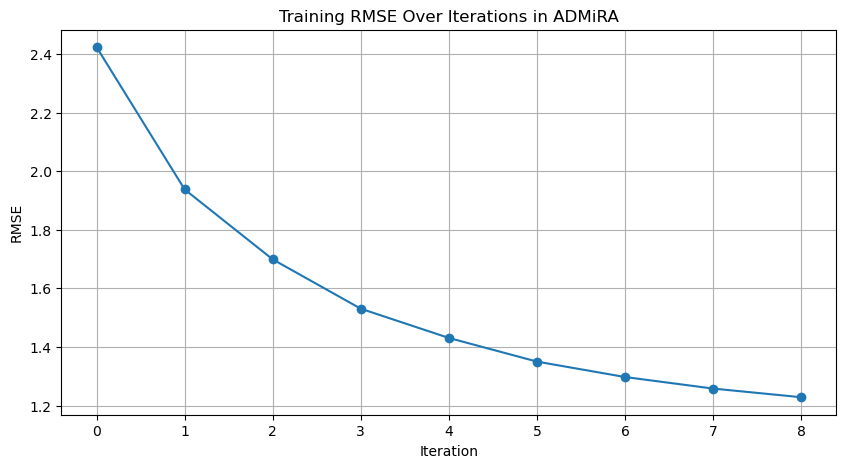

In [43]:
test_score, train_scores = train_and_evaluate_model(train_ratings_matrix, test_ratings_matrix, 'admira', return_train=True, rank=significant_rank)
print(f"ADMiRA RMSE: {test_score}")

# Plot the RMSE values
plt.figure(figsize=(10, 5))
plt.plot(train_scores, marker='o')
plt.title('Training RMSE Over Iterations in ADMiRA')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid()
plt.show()

# 4. Conclusion
Compare the results (RMSE, computational time) with the 3 approaches. Conclude about the best approach to keep in your
example and give potential limits on the methodologies.

- **Singular Value Thresholding (SVT)** provided an RMSE of 1.954 in approximately 12 seconds.
- **Singular Value Projection (SVP)** achieved a better RMSE of 1.505 in a shorter time of approximately 7 seconds.
- **ADMiRA** resulted in an RMSE of 1.631 but took significantly longer, about 1 minute and 15 seconds.

### Conclusion:
Considering both RMSE and computational efficiency, **SVP** appears to be the best choice. It offers a substantial reduction in RMSE compared to SVT and does so in less time. While ADMiRA does give a lower RMSE than SVT, it is not as efficient as SVP and takes much longer to compute. 

### Mathematical Context:
The effectiveness of SVP is rooted in its approach of iteratively projecting onto the space of matrices with a fixed rank, directly aiming to minimize the difference from the observed data. This directness and iterative refinement might explain its good performance in terms of both RMSE and speed.

SVT, while also iterative, introduces a soft-thresholding step on the singular values, which could lead to a more significant reduction in matrix rank per iteration, potentially causing a higher RMSE if the rank cut-off is not well-tuned.

ADMiRA, though it has the highest computational cost, uses a more sophisticated approach to iteratively build a subspace that best approximates the data. This method can lead to a lower RMSE, as seen in your results, but at the cost of increased complexity and computation time.

### Potential Limits:
- **SVT** can be limited by the choice of the threshold parameter. If not chosen correctly, it can either lead to too much data loss or insufficient compression, resulting in suboptimal RMSE.
- **SVP** may face challenges when the rank is not a good measure of the underlying data structure or when the data is not well-suited for low-rank approximations.
- **ADMiRA** requires significant computational resources, making it less practical for very large datasets or real-time applications. Its performance is also highly dependent on the choice of the rank and other hyperparameters.